# Bank Deposit Classification

In [1]:
import numpy as np
import pandas as pd

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Data Encoding and Scaling
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# For Imbalanced Data
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.pipeline import Pipeline

# For Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# For Fine Tuning the ANN
import keras_tuner as kt

# For ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC 

# For Fine Tuning the ML Models
from sklearn.model_selection import RandomizedSearchCV

# For Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score


import warnings
warnings.filterwarnings('ignore')

# Banking Dataset

#### Problem Statement
To predict if the client will subscribe to a term deposit, hence, **Classification Problem**

#### Features:
1. **Age** - Person's age
2. **Job** - Type of job
3. **Marital** - Marital status
4. **Education** - Education status
5. **Default** - Has default credit?
6. **Housing** -  Has housing loan?
7. **Loan** - Has personal loan?
8. **Contact** - Communication type
9. **Month** - Last contact month of year
10. **DayOfWeek** - Last contact day of week
11. **Duration** - Last contact duration (seconds)
12. **Campaign** - No. of contacts during marketing campaign (includes last contact)
13. **PDays** - No. of days passes after last campaign contact
14. **Previous** - No. of contacts before this campaign
15. **POutcome** - Outcome of previous campaign
16. **Y** - Has client subscribed to term deposit?  **(Target)**

# Import Data

In [2]:
df = pd.read_csv('BankData/new_train.csv')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [4]:
# Rename Columns
df.columns = ['Age','Job','Marital','Education','CreditDefault','HouseLoan','PersonalLoan',
              'Contact','LMonth','LDayofWeek','LDuration',
              'Campaign','PDays','PCampaign','POutcome','Y']

# Data Exploration - EDA
1. **Non-visual analysis**
- Missing value
- Unique values in categorical features
- Distribution of target feature  
2. **Visual Analysis**
- Countplots for frequency of categorical data
- Histograms of numeric data for disteibution analysis
- Boxplots for outlier analysis
- Violinplots for distribution of numerical features over target feature 
- Correlation heatmap of numerical features
- Stacked Barcharts for categorical features with target feature

#### Separate numeric and categorical columns

In [5]:
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols

['Age', 'LDuration', 'Campaign', 'PDays', 'PCampaign']

In [6]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('Y')
cat_cols

['Job',
 'Marital',
 'Education',
 'CreditDefault',
 'HouseLoan',
 'PersonalLoan',
 'Contact',
 'LMonth',
 'LDayofWeek',
 'POutcome']

## Non-Visual Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            32950 non-null  int64 
 1   Job            32950 non-null  object
 2   Marital        32950 non-null  object
 3   Education      32950 non-null  object
 4   CreditDefault  32950 non-null  object
 5   HouseLoan      32950 non-null  object
 6   PersonalLoan   32950 non-null  object
 7   Contact        32950 non-null  object
 8   LMonth         32950 non-null  object
 9   LDayofWeek     32950 non-null  object
 10  LDuration      32950 non-null  int64 
 11  Campaign       32950 non-null  int64 
 12  PDays          32950 non-null  int64 
 13  PCampaign      32950 non-null  int64 
 14  POutcome       32950 non-null  object
 15  Y              32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


In [8]:
df.shape

(32950, 16)

In [9]:
# Check missing values
df.isna().sum()

Age              0
Job              0
Marital          0
Education        0
CreditDefault    0
HouseLoan        0
PersonalLoan     0
Contact          0
LMonth           0
LDayofWeek       0
LDuration        0
Campaign         0
PDays            0
PCampaign        0
POutcome         0
Y                0
dtype: int64

In [10]:
df.describe()

,Age,LDuration,Campaign,PDays,PCampaign
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.014112,258.127466,2.560607,962.052413,0.174719
std,10.403636,258.975917,2.752326,187.951096,0.499025
min,17.000000,0.000000,1.000000,0.000000,0.000000
25%,32.000000,103.000000,1.000000,999.000000,0.000000
50%,38.000000,180.000000,2.000000,999.000000,0.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000
max,98.000000,4918.000000,56.000000,999.000000,7.000000


`In Pdays, 999 indicates that this is the first contact with the client. `

In [11]:
df.describe(include='object')

,Job,Marital,Education,CreditDefault,HouseLoan,PersonalLoan,Contact,LMonth,LDayofWeek,POutcome,Y
count,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,8314,19953,9736,26007,17254,27131,20908,11011,6857,28416,29238


#### Analysing the Target Variable 

In [12]:
df['Y'].value_counts()

Y
no     29238
yes     3712
Name: count, dtype: int64

In [13]:
df['Y'].value_counts(normalize=True)*100

Y
no     88.734446
yes    11.265554
Name: proportion, dtype: float64

## Visual Analysis

### Histogram of Numerical Data

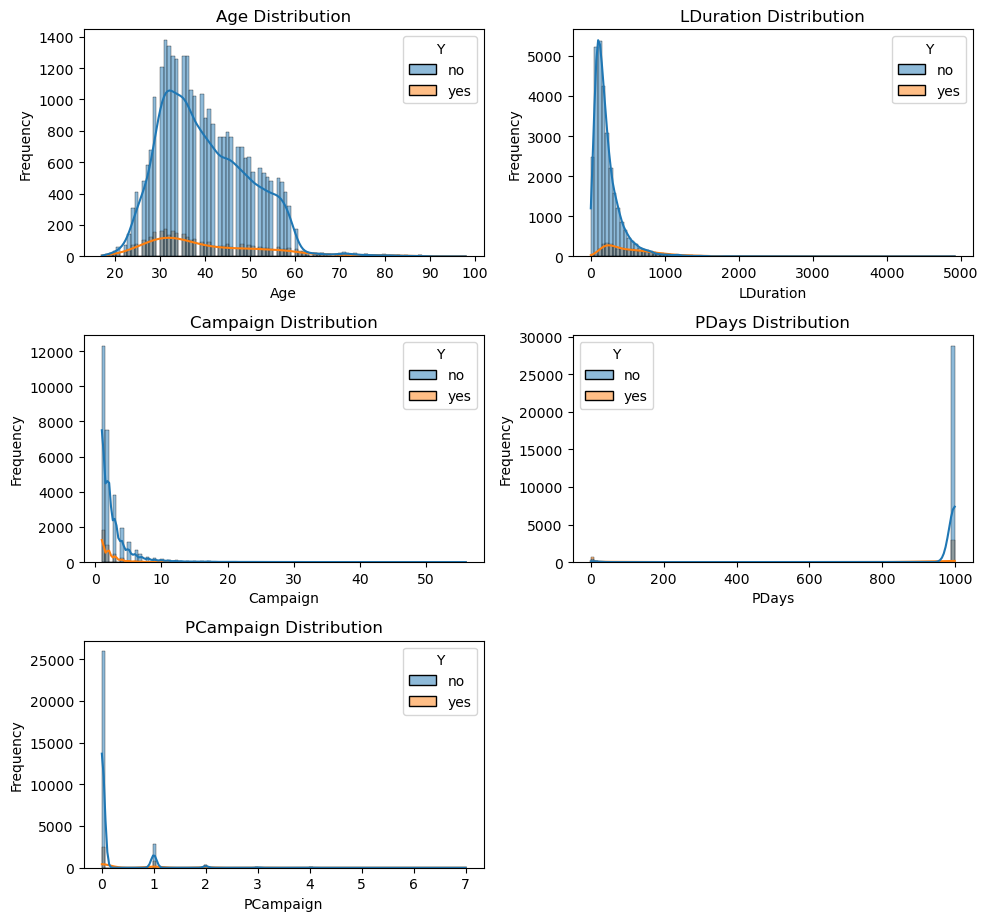

In [14]:
plt.figure(figsize=(10,15))

for i, col in enumerate (num_cols, 1):
    
    plt.subplot(5,2,i)
    sns.histplot(data=df,x=col,kde=True,bins=100,hue='Y')
    #plt.yscale("log")   # apply log transformation since data is very skewed
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

#### Observations on Histogram:
- Age is mostly in between 25-55 years. Those who subscribe to term deposit are between 25-45 years of age.
- Last contact duration (LDuration) shows that when class are longer than 3000 sec, subscription is more likely. So this is a strong feature for prediction. This has the best separation of target feature.
- if the number of contacts made during a campaign (Campaign) exceeds 6, it is detrimental to getting he client to subscribe. High campaign count does not result in successful conversions to term deposit.
- PDays at 999 can be ignored since they indicate first contact. Highest success is observed around PDay from 0-5 days. So delayed campiagns are not successful.
- Most clients have 0-3 contacts made in the previous campiagn (PCampign), of which most are unsuccessful. So previous unsuccessful contact maynot be successful beyond 0-3 contacts. 

### Boxplot of Numerical Data for Outliers

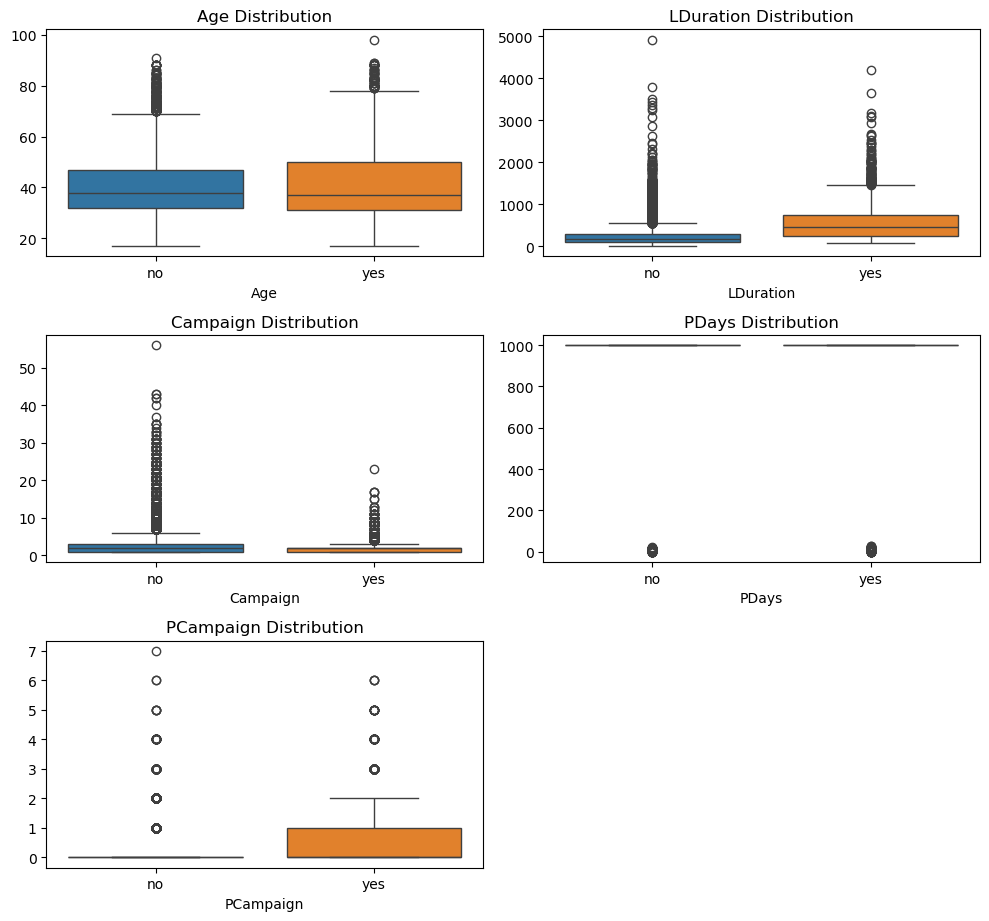

In [15]:
plt.figure(figsize=(10,15))

for i, col in enumerate (num_cols, 1):
    
    plt.subplot(5,2,i)
    sns.boxplot(data=df, x='Y', y=col, hue='Y')
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("")

plt.tight_layout()
plt.show()

### Violinplot for Distribution of Numerical Data

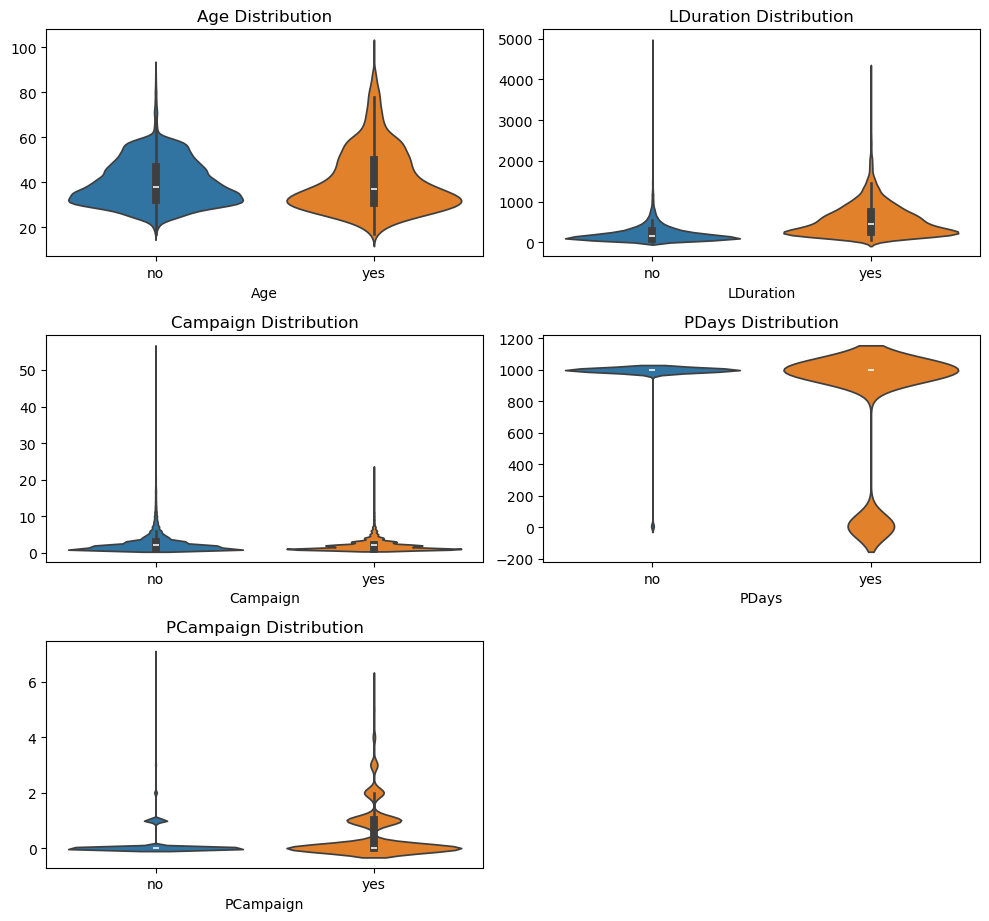

In [16]:
plt.figure(figsize=(10,15))

for i, col in enumerate (num_cols, 1):
    
    plt.subplot(5,2,i)
    sns.violinplot(data=df, x='Y', y=col, hue='Y')
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("")

plt.tight_layout()
plt.show()

#### Observations on Box plot and Violin plot:
- The age median for both groups is between 35-40 and both groups show outliers beyond 80 years of age.
- The last contact duration median for those subscribe is more than those who don't. The outliers for long contact duration for success, starts at a higher value than the unsuccessful contacts.
- The number of contacts made during a campaign is less for the sucessful ones. However, outliers for successful contacts indicate that repeated calls (10-30 times) can be get a client to subscribe.
- Previous days since last compaign (PDays) indicates that majority of clinets have not been contacted. (Might be possible to convert to categorical)
- The PCampaign shows that clinets who subscribe are more likely to have been contacted during a previous campaign. So even an unsuccessful contact can yield success later on.

### Pairplot of Numerical Columns with Target

<Figure size 1000x1000 with 0 Axes>

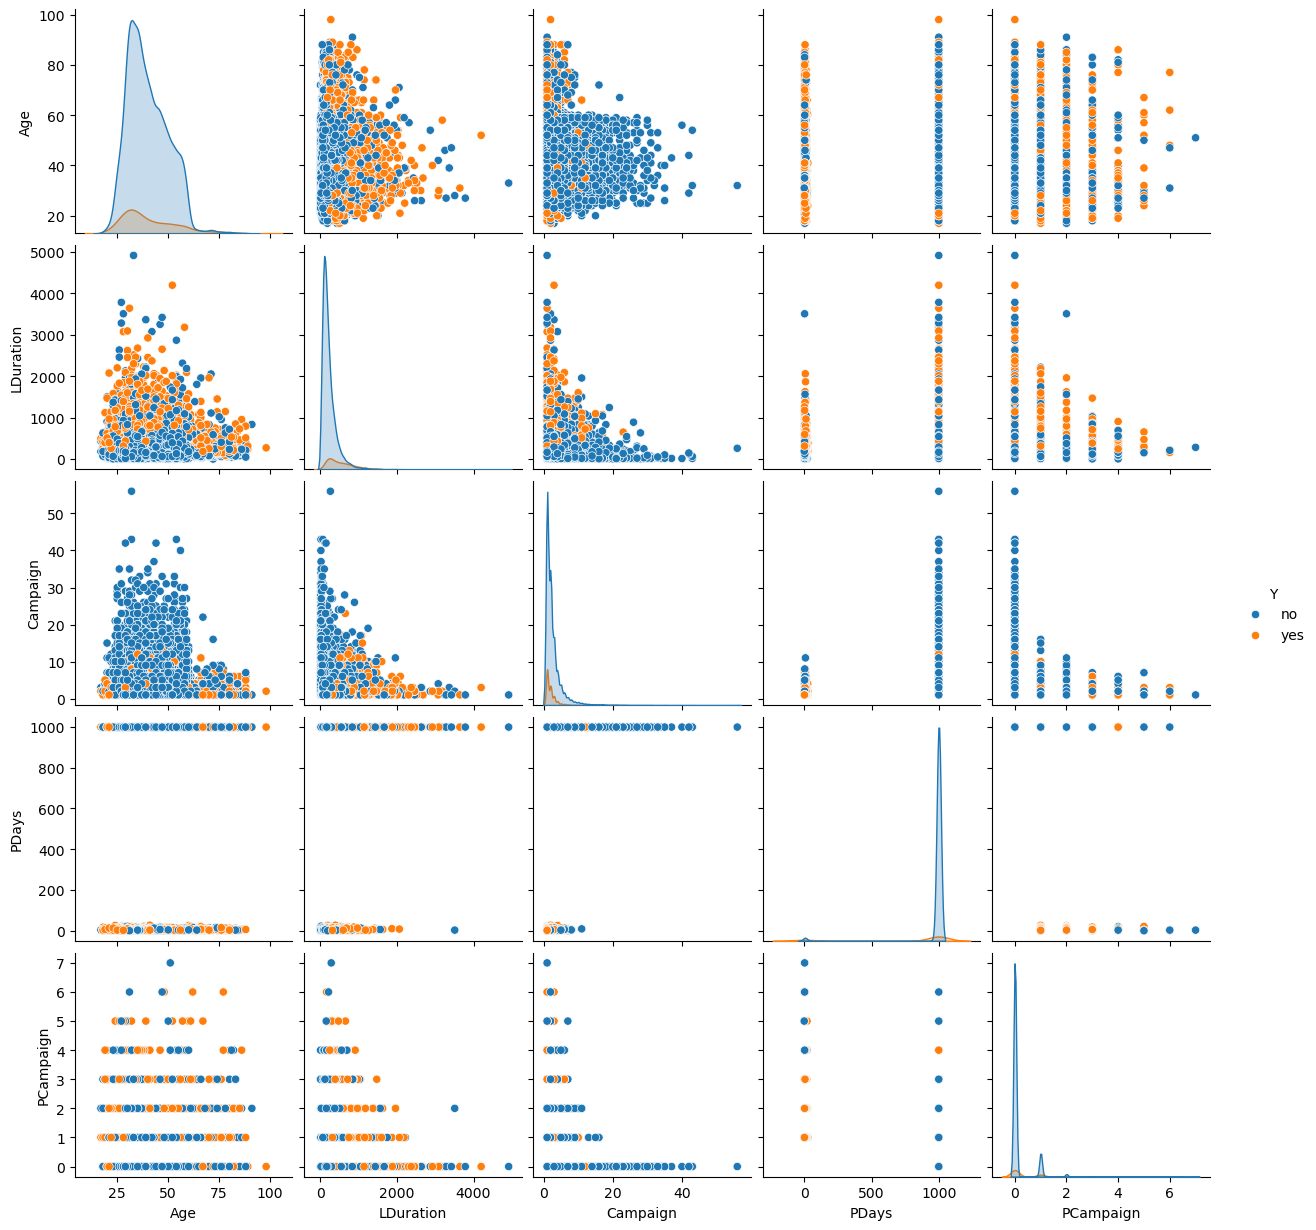

In [11]:
plot_cols = num_cols + ['Y']

plt.figure(figsize=(10, 10))
sns.pairplot(data=df[plot_cols], hue='Y', diag_kind='kde')
plt.show()

#### Observations on Pair Plot:
- LDuration vs Campaign shows that most successful subscriptions are made when LDuration is high and Campaign is high.
- There is strong class imbalance with Campaign feature.

### Countplots for Frequency of Categorical Data

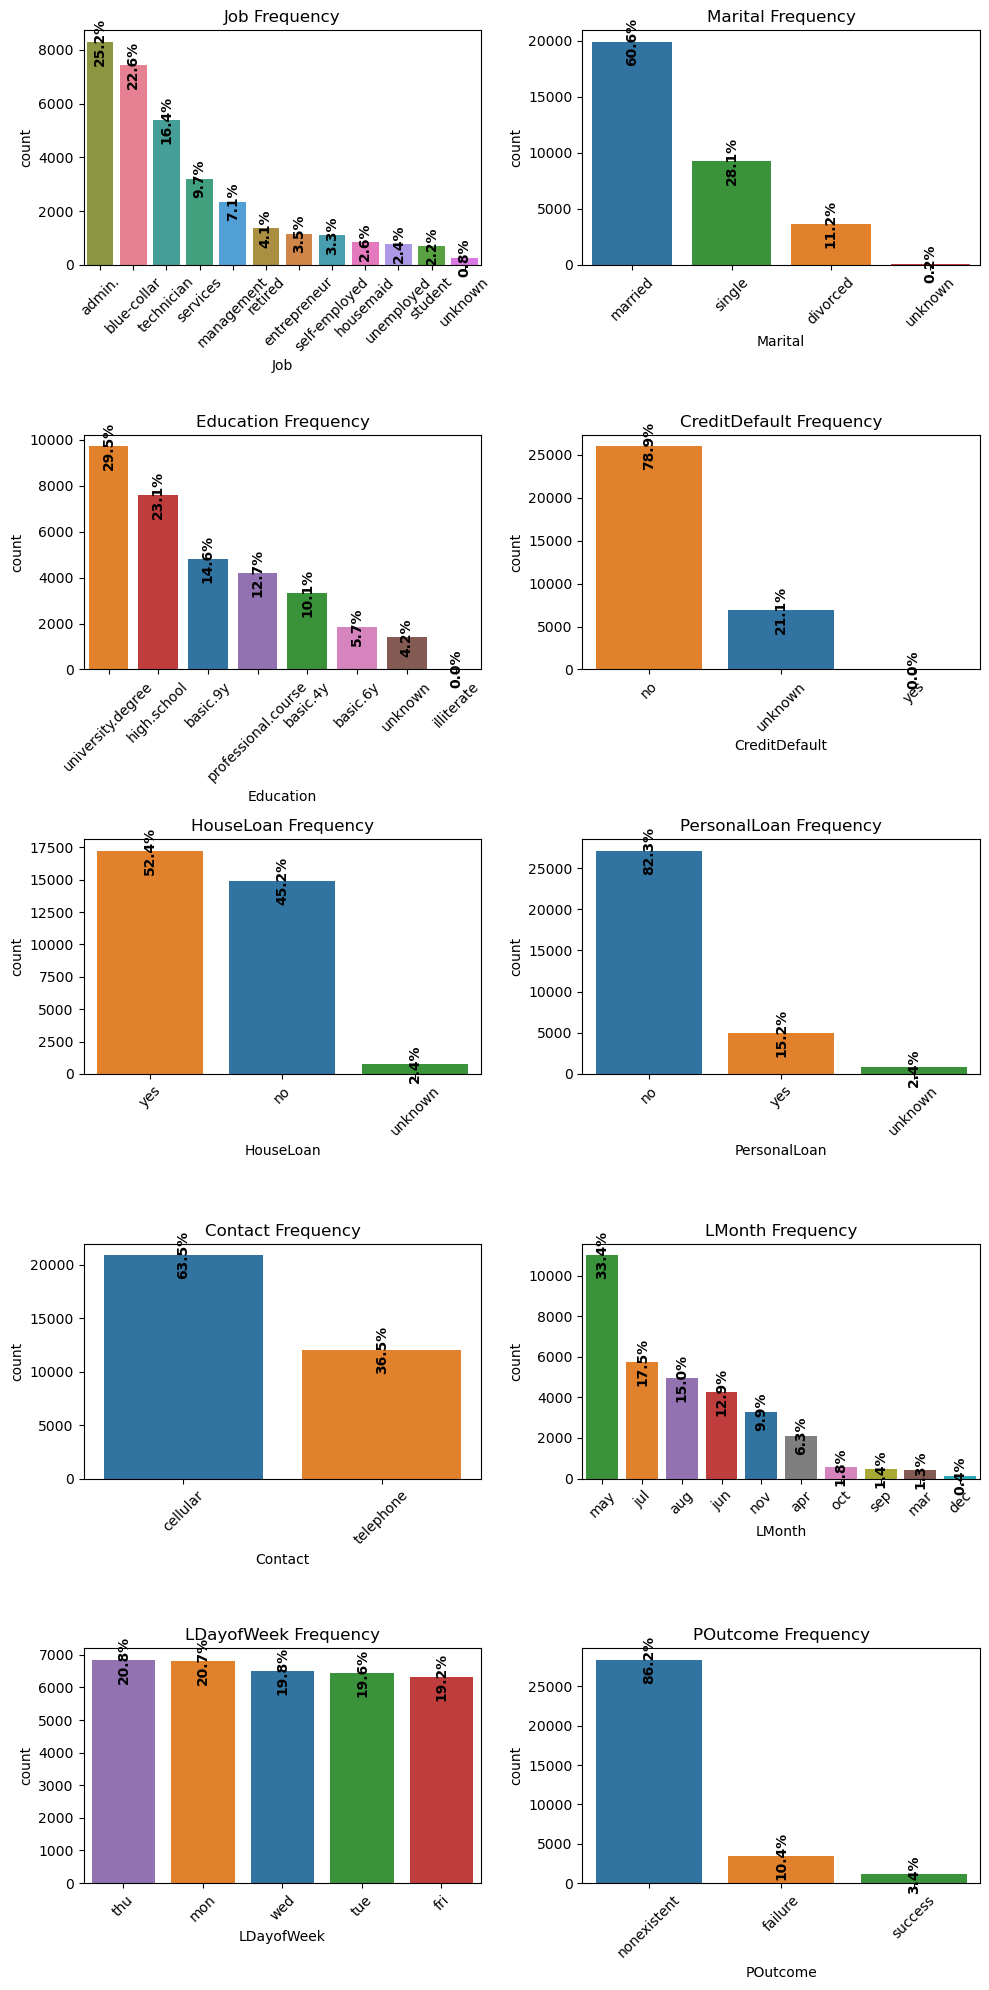

In [17]:
plt.figure(figsize=(10,20))

for i, col in enumerate(cat_cols,1):
    
    plt.subplot(5,2,i)
    ax = sns.countplot(data=df, x=col, hue=col, order=df[col].value_counts().index)
    plt.title(f"{col} Frequency")
    plt.xticks(rotation=45)

    for p in ax.patches:
        height = p.get_height()
        percent = 100 * height / len(df[col])
        ax.annotate(
            f'{percent:.1f}%',
            (p.get_x() + p.get_width()/2, height-1),
            ha='center', va='center', color='black', rotation=90,     
            fontsize=10, fontweight='bold')
            
plt.tight_layout()
plt.show()

#### Observations on Count Plot:
- Most of the clients have jobs in admin, blue-collar, technician and services.
- More than half of the clients are married.
- Most of the clients have education of university, highschool, basic9y and preofessional course.
- Most of the clients are not default in credit and the rest are unknown. (Highly imbalanced feature)
- More clients have a house loan than those who do not.
- Most clients do not have a personal loan. (Highly imbalanced feature)
- The mode of communication is mostly over cellular phone than telephone.
- The last month of contact is mostly in May, followed by July and August. 
- The last contact day of week is pretty uniform across Monday to Friday.
- The outcome of the previous campaign is mostly nonexsistent which means no previous contact was made. But if contact was made, the rate of failure is more that that of success.

### Stacked Barcharts for categorical features with target feature

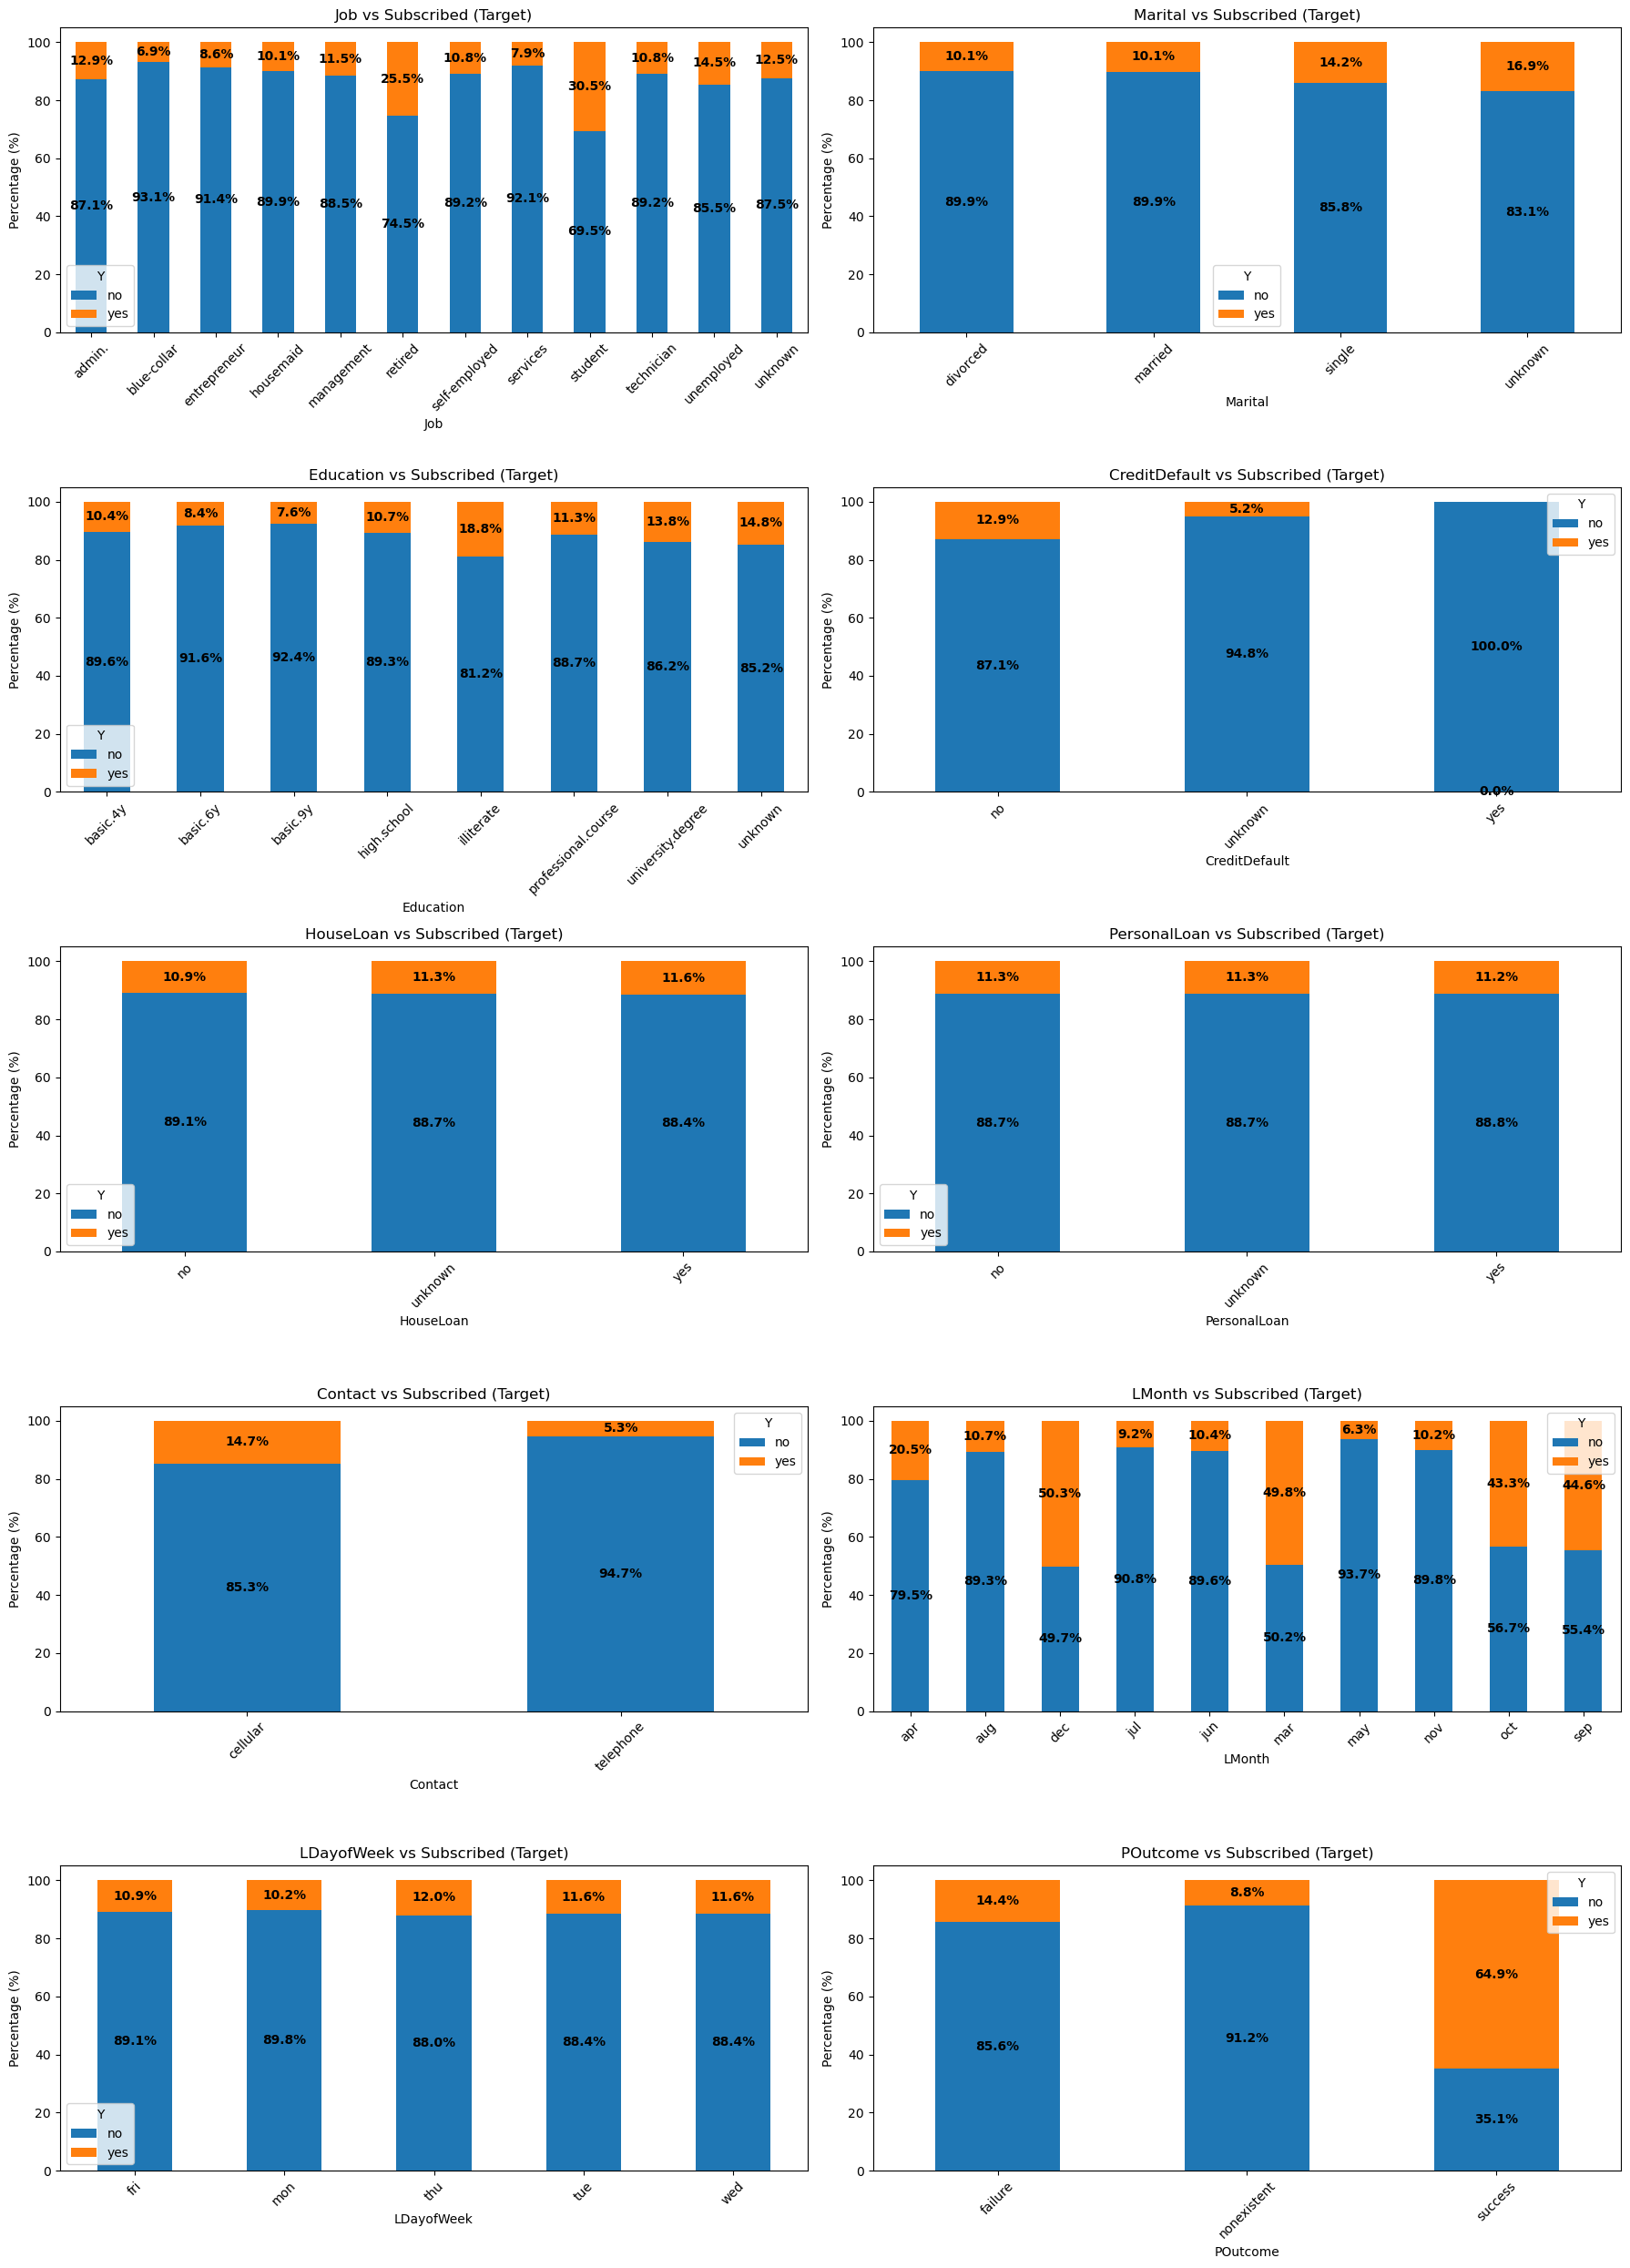

In [18]:
plt.figure(figsize=(18, 25))

for i, col in enumerate(cat_cols, 1):

    # Create cross-tab table of counts
    ct = pd.crosstab(df[col], df['Y'])

    # Normalize to get row-wise proportions
    ct_norm = ct.div(ct.sum(axis=1), axis=0) * 100

    plt.subplot(5, 2, i)
    
    # Stacked bar chart
    ct_norm.plot(kind='bar', stacked=True, ax=plt.gca())

    plt.title(f"{col} vs Subscribed (Target)")
    plt.ylabel("Percentage (%)")
    plt.xlabel(col)
    plt.xticks(rotation=45)

    # Add percentage labels inside the stack
    for container in plt.gca().containers:
        for bar in container:
            height = bar.get_height()
            plt.gca().annotate(
                f"{height:.1f}%", 
                (bar.get_x() + bar.get_width()/2, bar.get_y() + height/2),
                ha="center", va="center", color="black", fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

#### Observations on Stacked Barcharts
- Students and retired clients have a double the subsctiption rate than other jobs.
- Single clients are most liekly to subscribe, though not by much.
- Clients having education of university and professional course are more likely to subscribe, apart from the illiterate (which is a much smaller sample).
- Successful subcriptions are from clients with no default credit, none from those having a credit default.
- The clients who take either housing or personal loan show similar subscription rate, wherether they took the loan or not. (Weak Predictor for Yes group)
- Communication via cellular is more effective than telephone for a successful subscription.
- The months of Dec, Mar, Sep, Oct shows a highly successful previous contact.
- The days of week of last contact show similar rate of subscription, regardless of the day. (Weak Predictor for Yes group) 
- The client who subscribed in a previous campaign is likely to do so again. (Strong Predictor)

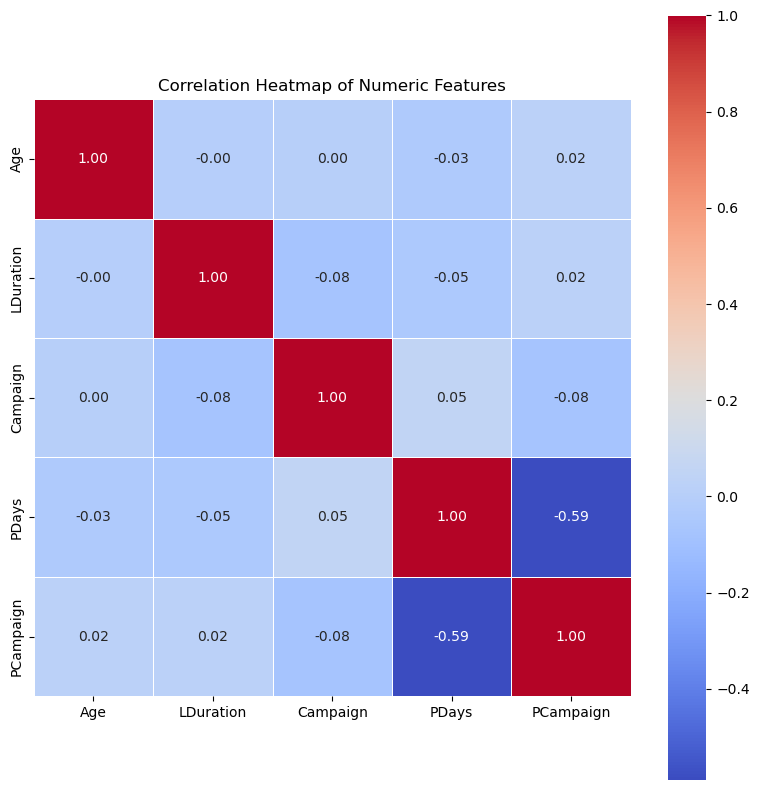

In [19]:
# Correlation Heatmap of Numeric Features

corr = df[num_cols].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True,fmt='.2f',cmap='coolwarm',linewidth=0.5,square=True)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

### Observations on HeatMap:
- Strongest negative correlation: PDays vs PCampaign (-0.59). This means that clients who were frequently contacted during the last campaign will have a more recent contact date.
- Overall, the correlation between the features is very low, so there is no multicollinearity of features.

## Overall EDA Insights:
- **LDuration**(longer calls) is the **strongest predictor**, followed by **PDays**(recent follow-ups), **PCampaign**(prior interaction), and **POutcome**(previous success).

- Multiple contacts (**PCampaign**) reduce success—aggressive calling is counterproductive.

- Demographic features contribute, **Age**(25-45), **Job**(Students, Retirees), **Education**(Higher levels), **Martital**(Single), but less strongly than campaign behaviour.

- **Contact** via cellular communication shows better success than telephone.

- **LMonth** shows campaign seasonality. More **campaigns in May, Jul, Aug**; but higher **success in Dec, Mar, Sept, Oct**.

- **Loan** (Housing or Personal) and **LDayofweek features** are **weak predictors**.

- The dataset has **class imbalance**, but **minimal multicollinearity**.

# Data Preprocessing

## Encoding Categorical Features
The following data encoding techniques will be used:  
  
**BinaryEncoding**:
- HouseLoan
- PersonalLoan
- Contact
- Y

**One-HotEncoding**:
- Marital
- CreditDefault
- POutcome

**LabelEncoding**:
- Job
- Education
- LMonth
- LDayofWeek

In [14]:
# Define columns for encoding

bin_cols = ['HouseLoan','PersonalLoan','Y'] # Contact feature encoded separately
onehot_cols = ['Marital','CreditDefault','POutcome']
lab_cols = ['Job','Education','LMonth','LDayofWeek']

In [15]:
# Binary Encoding

df['Contact'] = df['Contact'].map({'cellular':1, 'telephone':0})

df[bin_cols] = df[bin_cols].apply(lambda col: col.map({'yes':1,'no':0, 'unknown':-1}))


In [16]:
df[bin_cols].join(df['Contact']).head()

,HouseLoan,PersonalLoan,Y,Contact
0,0,0,0,1
1,0,0,0,0
2,0,0,1,1
3,1,0,0,0
4,0,0,0,1


In [17]:
# On-Hot Encoding

ohe = OneHotEncoder(sparse_output=False, drop=None)
encoded = pd.DataFrame(ohe.fit_transform(df[onehot_cols]), index=df.index,
                       columns=ohe.get_feature_names_out())
df = df.drop(columns=onehot_cols).join(encoded)

# Alternatively (without sklearn):
# df = pd.get_dummies(df, columns=onehot_cols, drop_first=False)

In [18]:
df.head()

,Age,Job,Education,HouseLoan,PersonalLoan,Contact,LMonth,LDayofWeek,LDuration,Campaign,...,Marital_divorced,Marital_married,Marital_single,Marital_unknown,CreditDefault_no,CreditDefault_unknown,CreditDefault_yes,POutcome_failure,POutcome_nonexistent,POutcome_success
0,49,blue-collar,basic.9y,0,0,1,nov,wed,227,4,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,37,entrepreneur,university.degree,0,0,0,nov,wed,202,2,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,78,retired,basic.4y,0,0,1,jul,mon,1148,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,36,admin.,university.degree,1,0,0,may,mon,120,2,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,59,retired,university.degree,0,0,1,jun,tue,368,2,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [19]:
# Label Encoder

emb_encoder = {} # to store encoder values for inverse transform

for col in lab_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    emb_encoder = le

`Include Embedding Layer in ANN to treat LabelEncoded values as indices and not numeric values.`

In [20]:
df[lab_cols].head()

,Job,Education,LMonth,LDayofWeek
0,1,2,7,4
1,2,6,7,4
2,5,0,3,1
3,0,6,6,1
4,5,6,4,3


## Scaling Numerical Features
The following data scaling techniques will be used:  
  
**StandardScaler**:
- Age

**RobustScaler**:
- LDuration
- Campaign
- PCampaign
- PDays

In [21]:
# Unique values in Numeric Columns

df[num_cols].nunique()

Age            75
LDuration    1467
Campaign       40
PDays          27
PCampaign       8
dtype: int64

In [22]:
# In PDays, value 999 skews data. So, set 999 to -1

df['PDays'] = df['PDays'].replace(999, -1)

In [23]:
# Define columns for scaling

std_cols = ['Age']

robust_cols = ['LDuration','Campaign','PCampaign','PDays']

In [24]:
# Create scaler objects 

standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

In [25]:
# Fit and Transform columns

df[std_cols] = standard_scaler.fit_transform(df[std_cols])
df[robust_cols] = robust_scaler.fit_transform(df[robust_cols])

scaled_num_cols = std_cols + robust_cols

In [26]:
df[scaled_num_cols].describe()

,Age,LDuration,Campaign,PCampaign,PDays
count,3.295000e+04,32950.000000,32950.000000,32950.000000,32950.000000
mean,2.510620e-16,0.361701,0.280303,0.174719,0.260303
std,1.000015e+00,1.198963,1.376163,0.499025,1.521547
min,-2.212156e+00,-0.833333,-0.500000,0.000000,0.000000
25%,-7.703301e-01,-0.356481,-0.500000,0.000000,0.000000
50%,-1.935999e-01,0.000000,0.000000,0.000000,0.000000
75%,6.714954e-01,0.643519,0.500000,0.000000,0.000000
max,5.573702e+00,21.935185,27.000000,7.000000,28.000000


In [27]:
# Save Pre-processed Data
df.to_csv('Pre_processed.csv', index=False)

`Pre_processed.csv consists of data after scaling and encoding.`

## Imbalanced Data
This can be handled by:
1. SMOTE
2. Borderline-SMOTE
3. ADASYN

In [2]:
df = pd.read_csv("Pre_processed.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    32950 non-null  float64
 1   Job                    32950 non-null  int64  
 2   Education              32950 non-null  int64  
 3   HouseLoan              32950 non-null  int64  
 4   PersonalLoan           32950 non-null  int64  
 5   Contact                32950 non-null  int64  
 6   LMonth                 32950 non-null  int64  
 7   LDayofWeek             32950 non-null  int64  
 8   LDuration              32950 non-null  float64
 9   Campaign               32950 non-null  float64
 10  PDays                  32950 non-null  float64
 11  PCampaign              32950 non-null  float64
 12  Y                      32950 non-null  int64  
 13  Marital_divorced       32950 non-null  float64
 14  Marital_married        32950 non-null  float64
 15  Ma

In [4]:
# Separate Features and Target

X = df.drop('Y',axis=1)
y = df['Y']

In [5]:
# Split into Train and Test Sets

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle=True,
                                                    random_state=32,stratify=y)

In [6]:
print("Train Data:",X_train.shape, y_train.shape)
print("Test Data:",X_test.shape, y_test.shape)

Train Data: (23065, 22) (23065,)
Test Data: (9885, 22) (9885,)


In [7]:
# Applying Oversampling Techniques

#sampler =  SMOTE(random_state=32)
sampler = BorderlineSMOTE(kind='borderline-1',random_state=32) 

X_train_sm, y_train_sm = sampler.fit_resample(X_train, y_train)

print('Original Class Balance:',y_train.value_counts(),'\n')

print('Oversampled Class Balance:',y_train_sm.value_counts(),'\n')

Original Class Balance: Y
0    20467
1     2598
Name: count, dtype: int64 

Oversampled Class Balance: Y
0    20467
1    20467
Name: count, dtype: int64 



`Resampling with B-SMOTE showed better model performance than SMOTE`

# Vanilla ANN Model

In [8]:
print("Balanced Train Data:\n",X_train_sm.shape, y_train_sm.shape)

Balanced Train Data:
 (40934, 22) (40934,)


In [9]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_sm.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')   # Binary classification
])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy','auc']
)

In [12]:
history = model.fit(
    X_train_sm, y_train_sm, validation_split=0.1, 
    epochs=20, batch_size=32, verbose=1 
)

Epoch 1/20
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8023 - auc: 0.8765 - loss: 0.4398 - val_accuracy: 0.8708 - val_auc: 0.0000e+00 - val_loss: 0.3982
Epoch 2/20
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8326 - auc: 0.9039 - loss: 0.3845 - val_accuracy: 0.8950 - val_auc: 0.0000e+00 - val_loss: 0.3336
Epoch 3/20
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8439 - auc: 0.9127 - loss: 0.3662 - val_accuracy: 0.8996 - val_auc: 0.0000e+00 - val_loss: 0.3136
Epoch 4/20
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8493 - auc: 0.9178 - loss: 0.3545 - val_accuracy: 0.8957 - val_auc: 0.0000e+00 - val_loss: 0.3201
Epoch 5/20
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8554 - auc: 0.9233 - loss: 0.3411 - val_accuracy: 0.9148 - val_auc: 0.0000e+00 - val_loss: 0.3116
Epoch 6/20
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8599 - auc: 0.9276 - loss: 0.3315 - val_accuracy: 0.9035 - val_auc: 0.0000e+00 - val_loss: 0.3265
Epoc

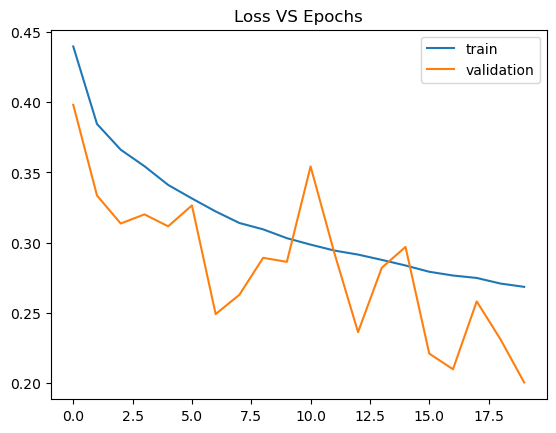

In [13]:
# Plot validation loss vs epochs
epochs = history.epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")
plt.show()

In [14]:
# Testing Model
y_pred = (model.predict(X_test) > 0.5).astype(int)

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


In [15]:
# Evaluating Model: Accuracy
loss, acc, auc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)
print("Test ROC-AUC:", auc)

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8385 - auc: 0.8933 - loss: 0.3431
Test Accuracy: 0.8385432362556458
Test ROC-AUC: 0.8932993412017822


In [16]:
# Evaluating Model: Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  index=['Actual No','Actual Yes'],
                  columns=['Predicted No','Predicted Yes'])
cm

,Predicted No,Predicted Yes
Actual No,7407,1364
Actual Yes,232,882


In [17]:
# Evaluating Model: Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.969630,0.844488,0.902742,8771.000000
1,0.392698,0.791741,0.525000,1114.000000
accuracy,0.838543,0.838543,0.838543,0.838543
macro avg,0.681164,0.818114,0.713871,9885.000000
weighted avg,0.904612,0.838543,0.860172,9885.000000


# Fine Tuning the ANN

In [18]:
def ANN_tuning(hp):
    model = Sequential()

    # Input Layer
    model.add(Dense(
        units=hp.Int('units_input', min_value=32, max_value=128, step=16),
        activation='relu',
        input_shape=(X_train_sm.shape[1],)))

    model.add(BatchNormalization())

    # Number of Hidden Layers (1-4 layers)
    for i in range(hp.Int('hidden_layers', 1, 4)):

        # Define the number of neurons in each layer (Search space: 16, 32, 64, 128)
        model.add(Dense(
            units=hp.Choice(f'units_{i}', values=[16, 32, 64, 128]),
            activation='relu'))
        
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    # Output Layer
    model.add(Dense(units=1, activation='sigmoid'))

    # Define training
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
        
    return model

In [19]:
# Initialize Tuner
tuner = kt.RandomSearch(
    ANN_tuning,
    objective=kt.Objective('val_auc', direction='max'), # Maximize AUC on validation data
    max_trials=15, # Total number of models to test
    executions_per_trial=1, # Number of models to train for each set of hyperparameters
    directory='keras_tuner_dir',
    project_name='bank_ann',
    overwrite=True
)

In [20]:
# Early Stopping
early_stop = EarlyStopping(
    monitor='val_auc',       # monitor validation AUC
    patience=5,              # stop if no improvement for 5 epochs
    restore_best_weights=True
)

# Search for the best hyperparameters
print("Starting Hyperparameter Search...")
tuner.search(
    X_train_sm, y_train_sm,
    validation_split=0.2,
    epochs=20, batch_size=32,
    callbacks=[early_stop]
)

Trial 15 Complete [00h 00m 24s]
val_auc: 0.0

Best val_auc So Far: 0.0
Total elapsed time: 00h 08m 26s


In [21]:
# Get the Best Model Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:\n")
for param in best_hps.values.items():
    print(param)

Best Hyperparameters:

('units_input', 128)
('hidden_layers', 3)
('units_0', 16)
('dropout_0', 0.30000000000000004)
('learning_rate', 0.01)
('units_1', 16)
('dropout_1', 0.1)
('units_2', 16)
('dropout_2', 0.1)


In [22]:
# Build best final model
best_model = tuner.get_best_models(num_models=1)[0]

In [23]:
# Training Final Model
final_history = best_model.fit(
    X_train_sm, y_train_sm,
    epochs=30, # Using more epochs for the final run
    validation_data=(X_test, y_test), 
    batch_size=32, verbose=1)

Epoch 1/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8233 - auc: 0.8888 - loss: 0.4092 - val_accuracy: 0.8070 - val_auc: 0.8865 - val_loss: 0.4111
Epoch 2/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8303 - auc: 0.8979 - loss: 0.3917 - val_accuracy: 0.7678 - val_auc: 0.8794 - val_loss: 0.4428
Epoch 3/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8345 - auc: 0.9004 - loss: 0.3884 - val_accuracy: 0.8415 - val_auc: 0.8948 - val_loss: 0.3309
Epoch 4/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8422 - auc: 0.9056 - loss: 0.3745 - val_accuracy: 0.7571 - val_auc: 0.9030 - val_loss: 0.5076
Epoch 5/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8438 - auc: 0.9081 - loss: 0.3703 - val_accuracy: 0.8506 - val_auc: 0.8952 - val_loss: 0.3238
Epoch 6/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8457 - auc: 0.9100 - loss: 0.3670 - val_accuracy: 0.7582 - val_auc: 0.8943 - val_loss: 0.4954
Epoch 7/30
1280/1280 ━━━━━━━

In [24]:
# Testing Model
y_pred_tuned = (best_model.predict(X_test) > 0.5).astype(int)

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [25]:
# Evaluating Model: Accuracy & ROC-AUC
loss, acc, auc = best_model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)
print("Test ROC-AUC:", auc)

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.8625 - auc: 0.9002 - loss: 0.3000
Test Accuracy: 0.8625189661979675
Test ROC-AUC: 0.9002075791358948


In [26]:
# Evaluating Model: Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_tuned), 
                  index=['Actual No','Actual Yes'],
                  columns=['Predicted No','Predicted Yes'])
cm

,Predicted No,Predicted Yes
Actual No,7689,1082
Actual Yes,277,837


In [27]:
# Evaluating Model: Classification Report
report = classification_report(y_test, y_pred_tuned, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.965227,0.876639,0.918803,8771.000000
1,0.436165,0.751346,0.551929,1114.000000
accuracy,0.862519,0.862519,0.862519,0.862519
macro avg,0.700696,0.813993,0.735366,9885.000000
weighted avg,0.905604,0.862519,0.877457,9885.000000


# ML Models

Here, 3 ML Classifiers are considered:
1. Logistic Regression
2. Random Forest
3. XGBoost

In [48]:
# Logistic Regression
lr_param = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs','saga'] # lbfgs is for l2 only
}

In [49]:
# Random Forest
rf_param = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [50]:
# XGBoost
xgb_param = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [51]:
# Tune Parameters and Evaluate Models

def tune_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, model_name):
    print(f"\n{model_name}")
    
    tuner = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,
        scoring='roc_auc',  # maximize AUC for imbalanced data
        cv=5,               # validation
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit on training data (after SMOTE)
    tuner.fit(X_train, y_train)
    
    # Best hyperparameters
    print("Best Hyperparameters:", tuner.best_params_)
    
    # Predict on test set
    best_model = tuner.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Probability for AUC
    y_prob = best_model.predict_proba(X_test)[:,1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"\nTest Accuracy: {acc:.3f}, \nTest AUC: {auc:.4f}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix :")
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                      index=['Actual No','Actual Yes'],
                      columns=['Predicted No','Predicted Yes'])
    print(cm)

    
    return {'Model': model_name, 'Accuracy': acc, 'AUC': auc}


In [52]:
# Run Training and Testing for all Models

results = []

# Random Forest
results.append(tune_and_evaluate(RandomForestClassifier(random_state=42), 
                                 rf_param, X_train_sm, y_train_sm, X_test, y_test, "Random Forest"))

# XGBoost
results.append(tune_and_evaluate(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
                                 xgb_param, X_train_sm, y_train_sm, X_test, y_test, "XGBoost"))

# Logistic Regression
results.append(tune_and_evaluate(LogisticRegression(random_state=42), 
                                 lr_param, X_train_sm, y_train_sm, X_test, y_test, "Logistic Regression"))

results_df = pd.DataFrame(results)
print("\nModel Comparison\n")
print(results_df.sort_values(by='AUC', ascending=False))


Random Forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

Test Accuracy: 0.894, 
Test AUC: 0.9054
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8771
           1       0.53      0.51      0.52      1114

    accuracy                           0.89      9885
   macro avg       0.74      0.73      0.73      9885
weighted avg       0.89      0.89      0.89      9885

Confusion Matrix :
            Predicted No  Predicted Yes
Actual No           8275            496
Actual Yes           548            566

XGBoost
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Test Accuracy: 0.895, 
Test AUC: 0.9153
Classification Report:
    

# Comparing Models
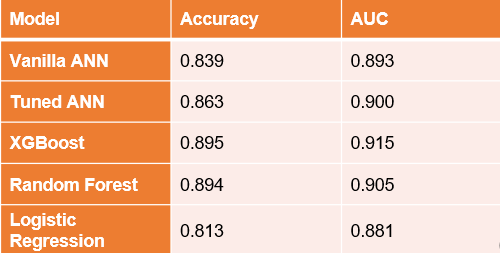

In [31]:
# Create dataframe with model comparison data
data = {
    'Model': ['Vanilla ANN', 'Tuned ANN', 'XGBoost', 'Random Forest', 'Logistic Regression'],
    'AUC': [0.8933, 0.9002, 0.9153, 0.9054, 0.8810]
}

df = pd.DataFrame(data)

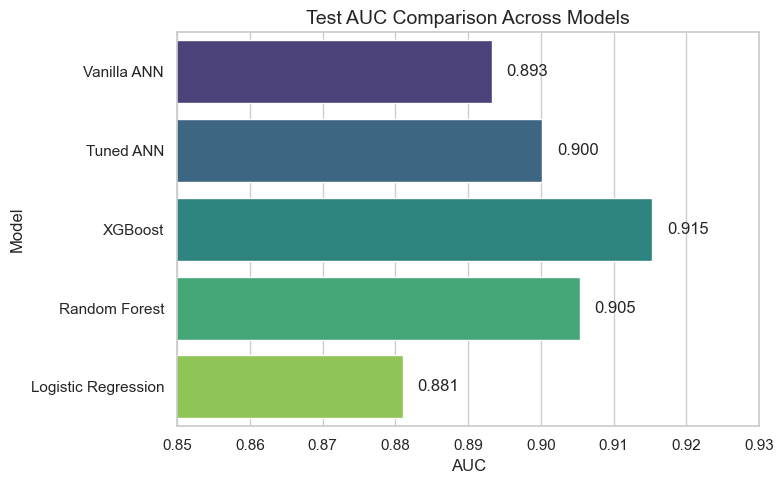

In [33]:
# Set plot style
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(8,5))
barplot = sns.barplot(x='AUC', y='Model', data=df, palette='viridis')

# Add values on bars
for i, auc in enumerate(df['AUC']):
    plt.text(auc + 0.002, i, f"{auc:.3f}", va='center')

# Titles and labels
plt.title('Test AUC Comparison Across Models', fontsize=14)
plt.xlabel('AUC')
plt.ylabel('Model')
plt.xlim(0.85, 0.93)

plt.tight_layout()
plt.show()

# Conclusion

- Tuned ANN significantly improved minority class prediction compared to the baseline ANN.
- While XGBoost slightly outperformed in AUC, ANN offers flexibility for further tuning and deployment.
- The data used here is structured, which is well suited to for ML models.

# Future Scope
- Consider Embedding layer in ANN to treat LabelEncoded values
- Can also try resampling with ADASYN to handle data imbalance
- Perform more intensive feature engineering on campaign behaviour